In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Count fraction of loop anchors overlapping peaks

### Rao datasets

In [ ]:
datasets = os.listdir('/DATA/users/magnitov/znf143/chipseq/public_data/rao_data/')
datasets = sorted([x for x in datasets if 'K562' in x and 'HiCCUPS' not in x and 'anchors' not in x])
datasets = sorted([x for x in datasets if '.narrowPeak' in x or '.bed' in x])

k562_loops = '/DATA/users/magnitov/znf143/chipseq/public_data/rao_data/Rao_K562_HiCCUPS_loop_anchors.bed'
total = len(pd.read_csv(k562_loops, sep = '\t', header = None))
folder_loops = '/DATA/users/magnitov/znf143/chipseq/public_data/rao_data/'

k562_overlap_fractions = []
for i in range(0, len(datasets)):
    p = subprocess.run(["bedtools", "intersect", 
                        "-a", k562_loops,
                        "-b", folder_loops + datasets[i],
                        "-wa"], 
                        stdout=subprocess.PIPE)
    overlap = len(np.unique(p.stdout.decode('utf-8').split('\n')))-1
    k562_overlap_fractions.append(overlap/total)

In [ ]:
k562_overlap_fractions_df = pd.DataFrame(k562_overlap_fractions,
                                         index = datasets, 
                                         columns = ['fraction_peak_loci'])
k562_overlap_fractions_df.to_csv('/DATA/users/magnitov/znf143/chipseq/public_data/rao_data/K562_loop_anchors_overlap_rao_datasets.txt', index = 1, header = 1, sep = '\t')

### ZNF143 datasets

In [ ]:
datasets = ['peaks_common', 'peaks_proteintech', 'peaks_flag']

k562_loops = '/DATA/users/magnitov/znf143/chipseq/public_data/rao_data/Rao_K562_HiCCUPS_loop_anchors.bed'
total = len(pd.read_csv(k562_loops, sep = '\t', header = None))
folder_loops = '/DATA/users/magnitov/znf143/chipseq/public_data/rao_data/'

k562_overlap_fractions = []
for i in range(0, len(datasets)):
    p = subprocess.run(["bedtools", "intersect", 
                        "-a", k562_loops,
                        "-b", folder_loops + datasets[i] + '.liftOver_hg19.bed',
                        "-wa"], 
                        stdout=subprocess.PIPE)
    overlap = len(np.unique(p.stdout.decode('utf-8').split('\n')))-1
    k562_overlap_fractions.append(overlap/total)

In [ ]:
k562_overlap_fractions_df = pd.DataFrame(k562_overlap_fractions,
                                         index = datasets, 
                                         columns = ['fraction_peak_loci'])
k562_overlap_fractions_df.to_csv('/DATA/users/magnitov/znf143/chipseq/public_data/rao_data/K562_loop_anchors_overlap_znf143_datasets.txt', index = 1, header = 1, sep = '\t')

## Plot enrichment and overlap of factors in loop anchors 

In [3]:
# Overlaps with loop anchors
overlaps = pd.read_csv('./rao_data/K562_loop_anchors_overlap_rao_datasets.txt', sep = '\t')

# Enrichment in loop anchors
enrichment = pd.read_csv('./rao_data/K562_loop_anchors_enrichment_rao_datasets.csv')
enrichment.columns = ['peaks', 'obs_overlaps', 'perm_overlaps', 'z-score']
enrichment['fc'] = enrichment['obs_overlaps']/enrichment['perm_overlaps']

k562_rao = overlaps.merge(enrichment, on = 'peaks')
k562_rao['fc_scaled'] = k562_rao['fc'] / np.mean(k562_rao['fc'])
k562_rao.sort_values('fc', ascending = False).head()

,peaks,fraction_peak_loci,obs_overlaps,perm_overlaps,z-score,fc,fc_scaled
115,wgEncodeAwgTfbsSydhK562Rad21UniPk.narrowPeak,0.708274,7425,857.24,172.3253,8.661518,3.413997
121,wgEncodeAwgTfbsSydhK562Smc3ab9263IggrabUniPk.n...,0.752963,8476,1168.74,119.9041,7.252255,2.858526
36,wgEncodeAwgTfbsHaibK562Rad21V0416102UniPk.narr...,0.796705,9796,1695.22,146.4786,5.778601,2.277676
138,wgEncodeAwgTfbsSydhK562Znf143IggrabUniPk.narro...,0.644737,7527,1478.23,92.2466,5.091900,2.007008
144,wgEncodeAwgTfbsUwK562CtcfUniPk.narrowPeak,0.804884,10521,2119.06,117.7592,4.964937,1.956964


In [4]:
# Overlaps with loop anchors
overlaps = pd.read_csv('./rao_data/K562_loop_anchors_overlap_znf143_datasets.txt', sep = '\t')
overlaps.columns = ['peaks', 'fraction_peak_loci']

# Enrichment in loop anchors
enrichment = pd.read_csv('./rao_data/K562_loop_anchors_enrichment_znf143_datasets.csv')
enrichment.columns = ['peaks', 'obs_overlaps', 'perm_overlaps', 'z-score']
enrichment['fc'] = enrichment['obs_overlaps']/enrichment['perm_overlaps']

k562_znf143 = overlaps.merge(enrichment, on = 'peaks')
k562_znf143['fc_scaled'] = k562_znf143['fc'] / np.mean(k562_rao['fc'])
k562_znf143.head()

,peaks,fraction_peak_loci,obs_overlaps,perm_overlaps,z-score,fc,fc_scaled
0,peaks_common,0.030583,267,135.01,10.4410,1.977631,0.779497
1,peaks_proteintech,0.554054,6434,1302.53,70.5796,4.939618,1.946984
2,peaks_flag,0.000711,6,3.87,0.9428,1.550388,0.611096


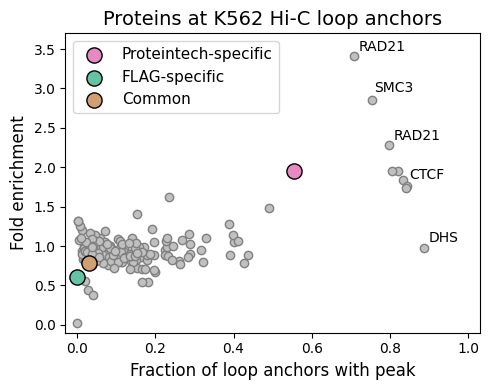

In [10]:
plt.figure(figsize = (5, 4))
plt.title('Proteins at K562 Hi-C loop anchors', fontsize = 14)
plt.scatter(k562_rao[k562_rao['peaks'] != 'wgEncodeAwgTfbsSydhK562Znf143IggrabUniPk.narrowPeak']['fraction_peak_loci'], 
            k562_rao[k562_rao['peaks'] != 'wgEncodeAwgTfbsSydhK562Znf143IggrabUniPk.narrowPeak']['fc_scaled'], 
            edgecolor = 'grey', lw = 1, color = 'silver')

plt.text(s = 'DHS', x = 0.9, y = 1.05)
plt.text(s = 'RAD21', x = 0.81, y = 2.35)
plt.text(s = 'RAD21', x = 0.72, y = 3.48)
plt.text(s = 'SMC3', x = 0.76, y = 2.95)
plt.text(s = 'CTCF', x = 0.85, y = 1.85)

plt.scatter(k562_znf143[k562_znf143['peaks'].isin(['peaks_proteintech'])]['fraction_peak_loci'], 
            k562_znf143[k562_znf143['peaks'].isin(['peaks_proteintech'])]['fc_scaled'], 
            s = 120, edgecolor = 'k', color = '#E78AC3', label = 'Proteintech-specific')
plt.scatter(k562_znf143[k562_znf143['peaks'].isin(['peaks_flag'])]['fraction_peak_loci'], 
            k562_znf143[k562_znf143['peaks'].isin(['peaks_flag'])]['fc_scaled'], 
            s = 120, edgecolor = 'k', color = '#66C2A5', label = 'FLAG-specific')
plt.scatter(k562_znf143[k562_znf143['peaks'].isin(['peaks_common'])]['fraction_peak_loci'], 
            k562_znf143[k562_znf143['peaks'].isin(['peaks_common'])]['fc_scaled'], 
            s = 120, edgecolor = 'k', color = '#D19F71', label = 'Common')
plt.xlabel('Fraction of loop anchors with peak', fontsize = 12)
plt.ylabel('Fold enrichment', fontsize = 12)
plt.xlim((-0.03, 1.03))
plt.ylim((-0.1, 3.7))
plt.legend(fontsize = 11, loc = 'upper left')

plt.tight_layout()
plt.show()